# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=60,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 60)
OOV context shape: (16562, 28)
Right context shape: (16562, 59)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[ 7.9354495e-03,  4.5638890e-41,  7.9354495e-03, ...,
         4.5637488e-41,  1.0786635e-40,  0.0000000e+00],
       [-3.8015554e-13,  4.5637488e-41, -1.4706136e-12, ...,
         4.5637488e-41, -1.4706830e-12,  4.5637488e-41],
       [ 1.0788176e-40,  0.0000000e+00, -3.8016508e-13, ...,
         0.0000000e+00, -3.8017376e-13,  4.5637488e-41],
       ...,
       [ 1.0961377e-40,  0.0000000e+00, -5.4341568e-14, ...,
         0.0000000e+00, -5.4342652e-14,  4.5637488e-41],
       [-1.4796272e-12,  4.5637488e-41,  1.0962918e-40, ...,
         4.5637488e-41,  1.0964320e-40,  0.0000000e+00],
       [-5.4343845e-14,  4.5637488e-41, -1.4797105e-12, ...,
         4.5637488e-41, -1.4775212e-12,  4.5637488e-41]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=4.4337 | F1Score=0.2825
Batch-100: NLLLoss=5.1571 | F1Score=0.2913
Batch-150: NLLLoss=6.7468 | F1Score=0.3065
Batch-200: NLLLoss=5.0201 | F1Score=0.3302
Batch-250: NLLLoss=4.1937 | F1Score=0.3477
Batch-300: NLLLoss=4.0454 | F1Score=0.3697
Batch-350: NLLLoss=3.5880 | F1Score=0.3854
Batch-400: NLLLoss=4.8193 | F1Score=0.4017
Batch-450: NLLLoss=4.0994 | F1Score=0.4132
Batch-500: NLLLoss=3.8128 | F1Score=0.4271
Batch-518: NLLLoss=3.9778 | F1Score=0.4307

Mean NLLLoss: 4.5461 | Mean F1Score: 0.3461

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.8031 | F1Score=0.5625
Batch-100: NLLLoss=3.6904 | F1Score=0.5831
Batch-150: NLLLoss=3.7168 | F1Score=0.5842
Batch-200: NLLLoss=2.6244 | F1Score=0.5947
Batch-250: NLLLoss=3.9023 | F1Score=0.6015
Batch-300: NLLLoss=2.5020 | F1Score=0.6086
Batch-350: NLLLoss=2.8565 | F1Score=0.6186
Batch-400: NLLLoss=2.6946 | F1Score=0.6246
Batch-450: NLLLoss=1.7076 | F1Score=0.6307
Batch-500: NLLLoss=2.1328 | F1Score=0.6368
Batch-518: NLLLoss=2.7442 | F1Score=0.6385

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.7117 | Mean F1Score: 0.6024

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.2878 | F1Score=0.7275
Batch-100: NLLLoss=1.3629 | F1Score=0.7300
Batch-150: NLLLoss=2.0225 | F1Score=0.7273
Batch-200: NLLLoss=2.2891 | F1Score=0.7269
Batch-250: NLLLoss=2.0655 | F1Score=0.7351
Batch-300: NLLLoss=1.9262 | F1Score=0.7391
Batch-350: NLLLoss=1.4374 | F1Score=0.7399
Batch-400: NLLLoss=1.4679 | F1Score=0.7436
Batch-450: NLLLoss=1.0594 | F1Score=0.7460
Batch-500: NLLLoss=1.4507 | F1Score=0.7487
Batch-518: NLLLoss=2.4797 | F1Score=0.7489

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7728 | Mean F1Score: 0.7360

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.9347 | F1Score=0.8094
Batch-100: NLLLoss=1.1773 | F1Score=0.8091
Batch-150: NLLLoss=0.6581 | F1Score=0.8124
Batch-200: NLLLoss=0.8882 | F1Score=0.8148
Batch-250: NLLLoss=1.6678 | F1Score=0.8166
Batch-300: NLLLoss=1.0316 | F1Score=0.8149
Batch-350: NLLLoss=1.8935 | F1Score=0.8151
Batch-400: NLLLoss=0.7242 | F1Score=0.8162
Batch-450: NLLLoss=1.3227 | F1Score=0.8180
Batch-500: NLLLoss=1.3595 | F1Score=0.8196
Batch-518: NLLLoss=1.1699 | F1Score=0.8202

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1406 | Mean F1Score: 0.8151

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.4609 | F1Score=0.9056
Batch-100: NLLLoss=0.7485 | F1Score=0.8975
Batch-150: NLLLoss=0.8025 | F1Score=0.8942
Batch-200: NLLLoss=0.6978 | F1Score=0.8920
Batch-250: NLLLoss=0.6177 | F1Score=0.8893
Batch-300: NLLLoss=1.1284 | F1Score=0.8856
Batch-350: NLLLoss=0.4495 | F1Score=0.8837
Batch-400: NLLLoss=0.3769 | F1Score=0.8814
Batch-450: NLLLoss=0.6897 | F1Score=0.8800
Batch-500: NLLLoss=0.7125 | F1Score=0.8787
Batch-518: NLLLoss=1.0185 | F1Score=0.8771

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.6683 | Mean F1Score: 0.8894

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.3568 | F1Score=0.9641
Batch-100: NLLLoss=0.3602 | F1Score=0.9620
Batch-150: NLLLoss=0.5291 | F1Score=0.9576
Batch-200: NLLLoss=0.1656 | F1Score=0.9568
Batch-250: NLLLoss=0.1709 | F1Score=0.9546
Batch-300: NLLLoss=0.3727 | F1Score=0.9531
Batch-350: NLLLoss=0.4272 | F1Score=0.9499
Batch-400: NLLLoss=0.3003 | F1Score=0.9486
Batch-450: NLLLoss=0.3211 | F1Score=0.9476
Batch-500: NLLLoss=0.2701 | F1Score=0.9459
Batch-518: NLLLoss=0.1964 | F1Score=0.9448

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3166 | Mean F1Score: 0.9546

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0508 | F1Score=0.9937
Batch-100: NLLLoss=0.0104 | F1Score=0.9922
Batch-150: NLLLoss=0.1100 | F1Score=0.9931
Batch-200: NLLLoss=0.1950 | F1Score=0.9920
Batch-250: NLLLoss=0.0578 | F1Score=0.9918
Batch-300: NLLLoss=0.1289 | F1Score=0.9911
Batch-350: NLLLoss=0.0302 | F1Score=0.9908
Batch-400: NLLLoss=0.1620 | F1Score=0.9900
Batch-450: NLLLoss=0.1340 | F1Score=0.9897
Batch-500: NLLLoss=0.1549 | F1Score=0.9897
Batch-518: NLLLoss=0.0720 | F1Score=0.9895

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0990 | Mean F1Score: 0.9917

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0221 | F1Score=0.9987
Batch-100: NLLLoss=0.0110 | F1Score=0.9991
Batch-150: NLLLoss=0.0129 | F1Score=0.9992
Batch-200: NLLLoss=0.0218 | F1Score=0.9991
Batch-250: NLLLoss=0.0136 | F1Score=0.9990
Batch-300: NLLLoss=0.0151 | F1Score=0.9989
Batch-350: NLLLoss=0.0193 | F1Score=0.9987
Batch-400: NLLLoss=0.0466 | F1Score=0.9986
Batch-450: NLLLoss=0.0172 | F1Score=0.9986
Batch-500: NLLLoss=0.0498 | F1Score=0.9986
Batch-518: NLLLoss=0.0090 | F1Score=0.9987

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0280 | Mean F1Score: 0.9987

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0063 | F1Score=1.0000
Batch-100: NLLLoss=0.0083 | F1Score=1.0000
Batch-150: NLLLoss=0.0049 | F1Score=1.0000
Batch-200: NLLLoss=0.0062 | F1Score=0.9998
Batch-250: NLLLoss=0.0070 | F1Score=0.9998
Batch-300: NLLLoss=0.0047 | F1Score=0.9996
Batch-350: NLLLoss=0.0094 | F1Score=0.9997
Batch-400: NLLLoss=0.2142 | F1Score=0.9996
Batch-450: NLLLoss=0.0078 | F1Score=0.9996
Batch-500: NLLLoss=0.0035 | F1Score=0.9996
Batch-518: NLLLoss=0.0048 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0108 | Mean F1Score: 0.9998

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0034 | F1Score=0.9997
Batch-100: NLLLoss=0.0048 | F1Score=0.9995
Batch-150: NLLLoss=0.0042 | F1Score=0.9995
Batch-200: NLLLoss=0.0060 | F1Score=0.9996
Batch-250: NLLLoss=0.0048 | F1Score=0.9994
Batch-300: NLLLoss=0.0051 | F1Score=0.9995
Batch-350: NLLLoss=0.0043 | F1Score=0.9996
Batch-400: NLLLoss=0.0059 | F1Score=0.9996
Batch-450: NLLLoss=0.0048 | F1Score=0.9996
Batch-500: NLLLoss=0.0043 | F1Score=0.9996
Batch-518: NLLLoss=0.0068 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0070 | Mean F1Score: 0.9996

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0034 | F1Score=0.9994
Batch-100: NLLLoss=0.0033 | F1Score=0.9991
Batch-150: NLLLoss=0.0047 | F1Score=0.9994
Batch-200: NLLLoss=0.0027 | F1Score=0.9995
Batch-250: NLLLoss=0.0025 | F1Score=0.9994
Batch-300: NLLLoss=0.0027 | F1Score=0.9995
Batch-350: NLLLoss=0.0029 | F1Score=0.9996
Batch-400: NLLLoss=0.0032 | F1Score=0.9996
Batch-450: NLLLoss=0.0037 | F1Score=0.9996
Batch-500: NLLLoss=0.0045 | F1Score=0.9996
Batch-518: NLLLoss=0.0028 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0055 | Mean F1Score: 0.9995

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0021 | F1Score=1.0000
Batch-100: NLLLoss=0.0020 | F1Score=1.0000
Batch-150: NLLLoss=0.0017 | F1Score=0.9999
Batch-200: NLLLoss=0.0025 | F1Score=0.9999
Batch-250: NLLLoss=0.0021 | F1Score=0.9998
Batch-300: NLLLoss=0.0029 | F1Score=0.9996
Batch-350: NLLLoss=0.0029 | F1Score=0.9996
Batch-400: NLLLoss=0.0034 | F1Score=0.9996
Batch-450: NLLLoss=0.0047 | F1Score=0.9997
Batch-500: NLLLoss=0.0032 | F1Score=0.9996
Batch-518: NLLLoss=0.0044 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0051 | Mean F1Score: 0.9998

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1407 | F1Score=0.9994
Batch-100: NLLLoss=0.0035 | F1Score=0.9994
Batch-150: NLLLoss=0.0027 | F1Score=0.9996
Batch-200: NLLLoss=0.0025 | F1Score=0.9994
Batch-250: NLLLoss=0.0057 | F1Score=0.9994
Batch-300: NLLLoss=0.0101 | F1Score=0.9993
Batch-350: NLLLoss=0.0467 | F1Score=0.9992
Batch-400: NLLLoss=0.3102 | F1Score=0.9883
Batch-450: NLLLoss=0.6766 | F1Score=0.9760
Batch-500: NLLLoss=0.3189 | F1Score=0.9655
Batch-518: NLLLoss=0.0191 | F1Score=0.9639

Huft 😥! Model not improved.
Mean NLLLoss: 0.1429 | Mean F1Score: 0.9934
Patience = 1/20❗

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0613 | F1Score=0.9450
Batch-100: NLLLoss=0.0204 | F1Score=0.9526
Batch-150: NLLLoss=0.0381 | F1Score=0.9551
Batch-200: NLLLoss=0.0378 | F1Score=0.9573
Batch-250: NLLLoss=0.0654 | F1Score=0.9589
Batch-300: NLLLoss=0.2337 | F1Score=0.9605
Batch-350: NLLLoss=0.0575 | F1Score=0.9627
Batch-400: NLLLoss=0.0658 | F1Score=0.9644
Batch-450: NLLLoss=0.2011 | F1Score=0.9656
Batch-500: NLLLoss=0.0986 | F1Score=0.9669
Batch-518: NLLLoss=0.0172 | F1Score=0.9669

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1375 | Mean F1Score: 0.9586

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0118 | F1Score=0.9953
Batch-100: NLLLoss=0.0107 | F1Score=0.9970
Batch-150: NLLLoss=0.0115 | F1Score=0.9976
Batch-200: NLLLoss=0.0233 | F1Score=0.9977
Batch-250: NLLLoss=0.0092 | F1Score=0.9979
Batch-300: NLLLoss=0.0053 | F1Score=0.9982
Batch-350: NLLLoss=0.0019 | F1Score=0.9983
Batch-400: NLLLoss=0.0012 | F1Score=0.9984
Batch-450: NLLLoss=0.0010 | F1Score=0.9986
Batch-500: NLLLoss=0.0046 | F1Score=0.9987
Batch-518: NLLLoss=0.0024 | F1Score=0.9987

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0114 | Mean F1Score: 0.9976

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0008 | F1Score=0.9994
Batch-100: NLLLoss=0.0017 | F1Score=0.9997
Batch-150: NLLLoss=0.0012 | F1Score=0.9996
Batch-200: NLLLoss=0.0029 | F1Score=0.9996
Batch-250: NLLLoss=0.0011 | F1Score=0.9997
Batch-300: NLLLoss=0.0010 | F1Score=0.9997
Batch-350: NLLLoss=0.0008 | F1Score=0.9998
Batch-400: NLLLoss=0.0016 | F1Score=0.9997
Batch-450: NLLLoss=0.0014 | F1Score=0.9997
Batch-500: NLLLoss=0.0016 | F1Score=0.9996
Batch-518: NLLLoss=0.0037 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0027 | Mean F1Score: 0.9996

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0015 | F1Score=0.9994
Batch-100: NLLLoss=0.0015 | F1Score=0.9997
Batch-150: NLLLoss=0.0011 | F1Score=0.9998
Batch-200: NLLLoss=0.0019 | F1Score=0.9998
Batch-250: NLLLoss=0.0006 | F1Score=0.9999
Batch-300: NLLLoss=0.0013 | F1Score=0.9998
Batch-350: NLLLoss=0.0008 | F1Score=0.9998
Batch-400: NLLLoss=0.0006 | F1Score=0.9996
Batch-450: NLLLoss=0.0008 | F1Score=0.9996
Batch-500: NLLLoss=0.0007 | F1Score=0.9996
Batch-518: NLLLoss=0.0004 | F1Score=0.9996

Huft 😥! Model not improved.
Mean NLLLoss: 0.0034 | Mean F1Score: 0.9997
Patience = 2/20❗

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0006 | F1Score=1.0000
Batch-100: NLLLoss=0.0010 | F1Score=1.0000
Batch-150: NLLLoss=0.0006 | F1Score=0.9997
Batch-200: NLLLoss=0.0010 | F1Score=0.9998
Batch-250: NLLLoss=0.0006 | F1Score=0.9996
Batch-300: NLLLoss=0.0013 | F1Score=0.9996
Batch-350: NLLLoss=0.0008 | F1Score=0.9996
Batch-400: NLLLoss=0.0004 | F1Score=0.9996
Batch-450: NLLLoss=0.0014 | F1Score=0.9997
Batch-500: NLLLoss=0.0012 | F1Score=0.9996
Batch-518: NLLLoss=0.0006 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0024 | Mean F1Score: 0.9997

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0006 | F1Score=0.9991
Batch-100: NLLLoss=0.0012 | F1Score=0.9995
Batch-150: NLLLoss=0.0009 | F1Score=0.9997
Batch-200: NLLLoss=0.0004 | F1Score=0.9998
Batch-250: NLLLoss=0.0010 | F1Score=0.9998
Batch-300: NLLLoss=0.0008 | F1Score=0.9997
Batch-350: NLLLoss=0.0005 | F1Score=0.9998
Batch-400: NLLLoss=0.0004 | F1Score=0.9998
Batch-450: NLLLoss=0.0015 | F1Score=0.9998
Batch-500: NLLLoss=0.0006 | F1Score=0.9998
Batch-518: NLLLoss=0.0005 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0011 | Mean F1Score: 0.9997

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0006 | F1Score=1.0000
Batch-100: NLLLoss=0.0003 | F1Score=1.0000
Batch-150: NLLLoss=0.0008 | F1Score=0.9996
Batch-200: NLLLoss=0.0006 | F1Score=0.9997
Batch-250: NLLLoss=0.0005 | F1Score=0.9997
Batch-300: NLLLoss=0.0007 | F1Score=0.9998
Batch-350: NLLLoss=0.0003 | F1Score=0.9998
Batch-400: NLLLoss=0.0004 | F1Score=0.9998
Batch-450: NLLLoss=0.0009 | F1Score=0.9999
Batch-500: NLLLoss=0.0005 | F1Score=0.9998
Batch-518: NLLLoss=0.0009 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0010 | Mean F1Score: 0.9998

TRAINING SUMMARY
Best NLLLoss      : 0.0010
Best F1Score      : 0.9998
Training duration : 29.684 minutes.
Training date     : 2022-10-11 16:36:41.840979+08:00


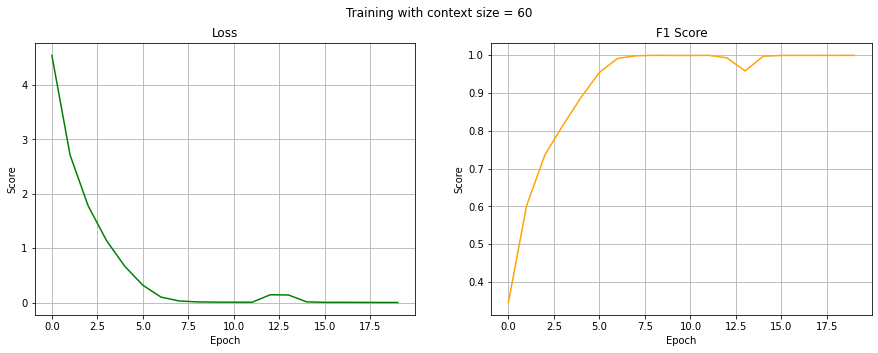

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[ 6.698871  , -1.3245914 , -1.8674408 , ...,  9.569626  ,
        -2.1662471 , -0.98780745],
       [ 2.2295864 , -3.0599332 ,  2.2954185 , ...,  3.5242825 ,
        -5.613352  ,  0.07378936],
       [-2.1575136 , -3.9093077 , -1.2659972 , ...,  5.6551905 ,
        -2.0701745 ,  0.29262128],
       ...,
       [ 0.07714042,  6.3622427 , -5.955932  , ...,  3.4798927 ,
        -2.1314087 ,  1.5145831 ],
       [ 8.589472  , -6.145585  , -6.052214  , ...,  1.9014851 ,
        -2.109405  , -2.4453042 ],
       [-5.4601884 ,  2.8406298 , -4.7926974 , ...,  1.9563768 ,
        -3.5715709 , -1.9058824 ]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[-0.2010,  0.1083, -0.0261,  ..., -0.0128,  0.1416,  0.2115],
                      [-0.1079,  0.0288,  0.1573,  ..., -0.2087,  0.1484, -0.1556],
                      [-0.1100, -0.2269,  0.2092,  ..., -0.1245, -0.0748,  0.0715],
                      ...,
                      [ 0.2555, -0.1144,  0.2789,  ..., -0.4207,  0.2757, -0.1824],
                      [-0.1595,  0.0588,  0.2040,  ..., -0.3466,  0.3150, -0.1479],
                      [ 0.1970, -0.1077,  0.4212,  ...,  0.2453,  0.1060, -0.1725]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[ 0.1261, -0.2350, -0.1784,  ..., -0.1030,  0.1706, -0.0300],
                      [ 0.0941, -0.1502, -0.2151,  ...,  0.3190,  0.1756, -0.0158],
                      [ 0.1052, -0.1789,  0.1593,  ...,  0.1615, -0.2090,  0.0246],
                      ...,
                      [ 0.1292,  0.1250, -0.0524,  ..., -0.0766, -0.341